In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:/Downloads/archive (1)/lung_colon_image_set/colon_image_sets",  # Directory path should be outside the quotes
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['colon_aca', 'colon_n']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1]


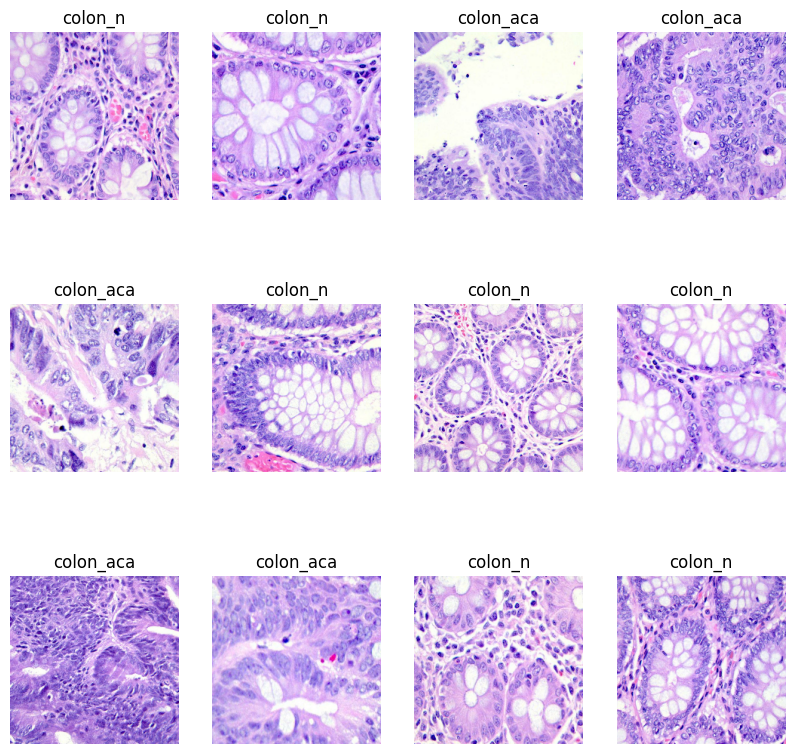

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

313

In [8]:
train_size = 0.8
len(dataset)*train_size

250.4

In [9]:
train_ds = dataset.take(250)
len(train_ds)

250

In [10]:
test_ds = dataset.skip(250)
len(test_ds)

63

In [11]:
val_size=0.1
len(dataset)*val_size

31.3

In [12]:
val_ds = test_ds.take(31)
len(val_ds)

31

In [13]:
test_ds = test_ds.skip(31)
len(test_ds)

32

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

250

In [17]:
len(val_ds)

31

In [18]:
len(test_ds)

32

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 222, 222, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 111, 111, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 54, 54, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 52, 52, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
250/250 [==============================] - 849s 3s/step - loss: 0.7033 - accuracy: 0.5139 - val_loss: 0.6882 - val_accuracy: 0.5484
Epoch 2/10
250/250 [==============================] - 507s 2s/step - loss: 0.5244 - accuracy: 0.7173 - val_loss: 0.2896 - val_accuracy: 0.8841
Epoch 3/10
250/250 [==============================] - 490s 2s/step - loss: 0.3721 - accuracy: 0.8418 - val_loss: 0.2724 - val_accuracy: 0.8770
Epoch 4/10
250/250 [==============================] - 487s 2s/step - loss: 0.1974 - accuracy: 0.9177 - val_loss: 0.1463 - val_accuracy: 0.9405
Epoch 5/10
250/250 [==============================] - 487s 2s/step - loss: 0.1342 - accuracy: 0.9444 - val_loss: 0.0734 - val_accuracy: 0.9677
Epoch 6/10
250/250 [==============================] - 485s 2s/step - loss: 0.0835 - accuracy: 0.9668 - val_loss: 0.0852 - val_accuracy: 0.9597
Epoch 7/10
250/250 [==============================] - 480s 2s/step - loss: 0.0845 - accuracy: 0.9656 - val_loss: 0.0568 - val_accuracy: 0.9788

In [28]:
scores = model.evaluate(test_ds)

32/32 [==============================] - 72s 505ms/step - loss: 0.0356 - accuracy: 0.9873


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

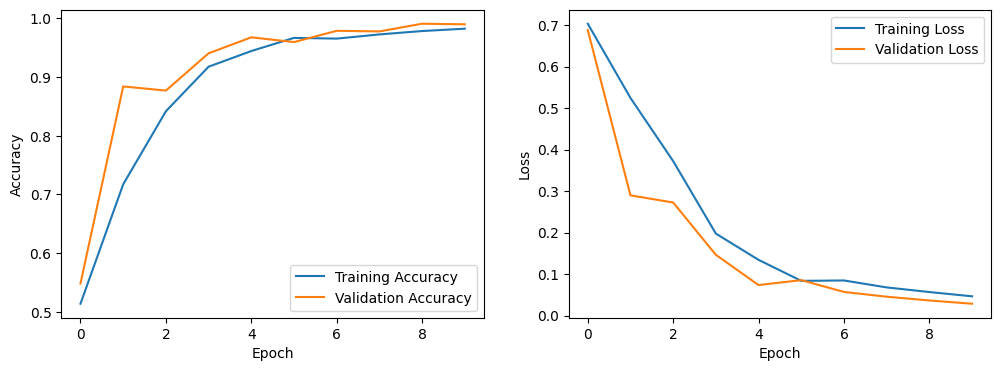

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


first image to predict
actual label: colon_n
1/1 [==============================] - 2s 2s/step
predicted label: colon_n


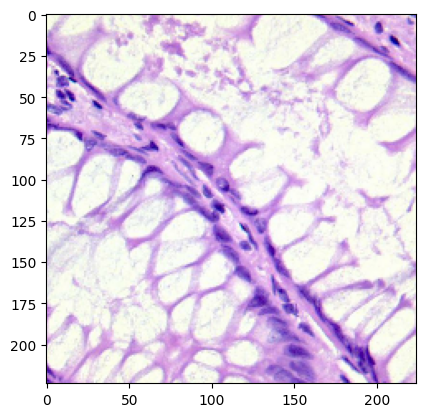

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 127ms/step


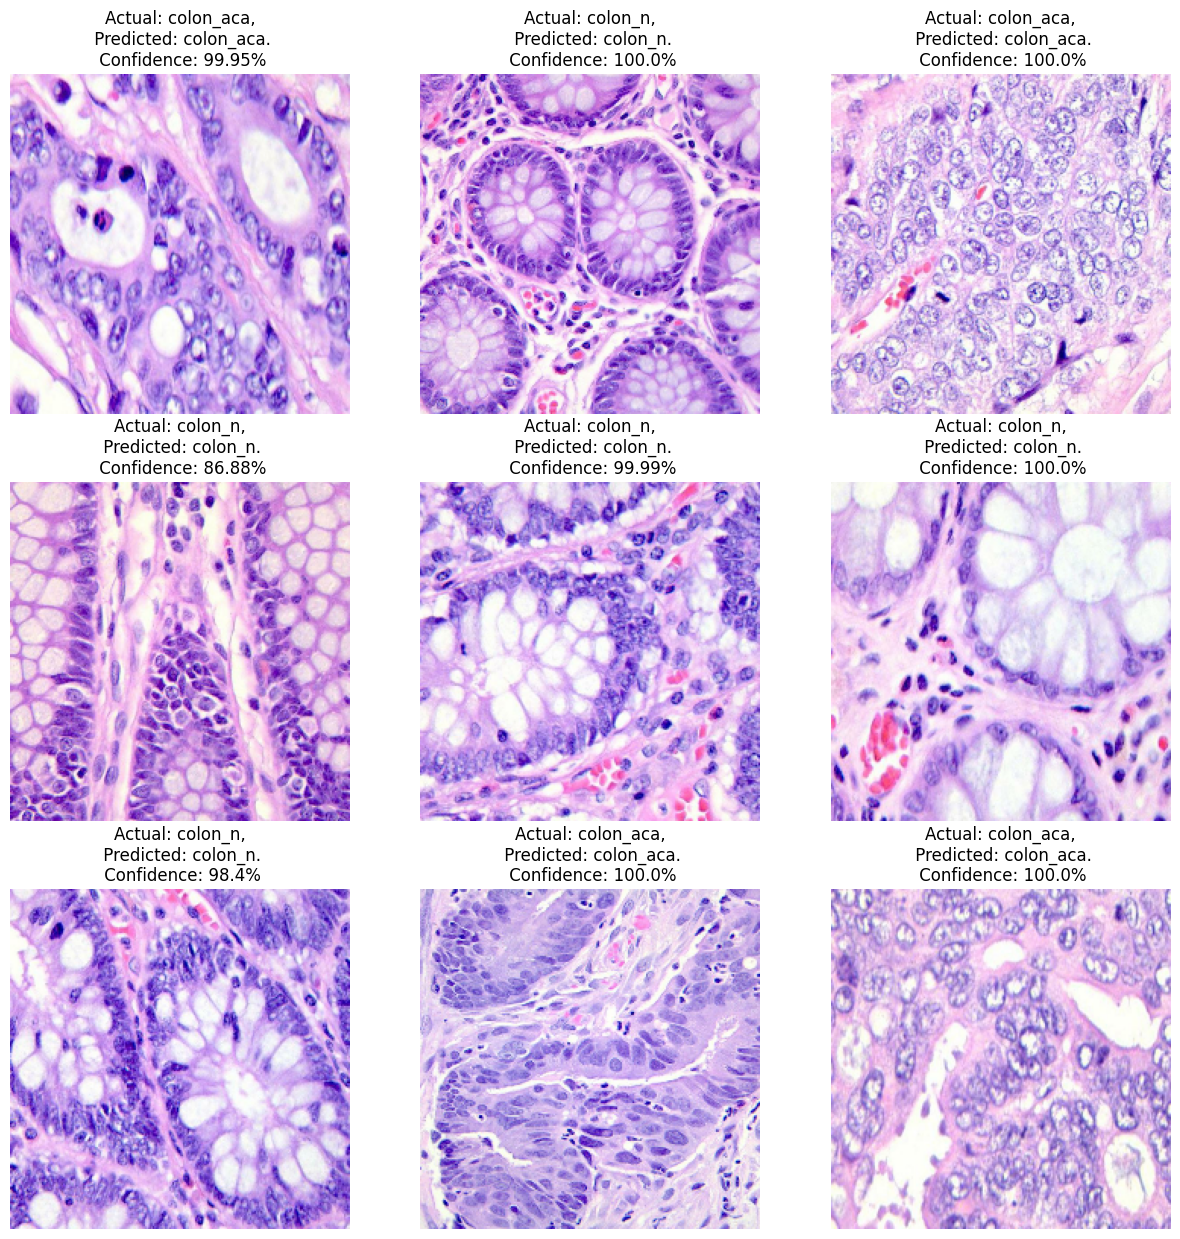

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(20):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 1s 719ms/step


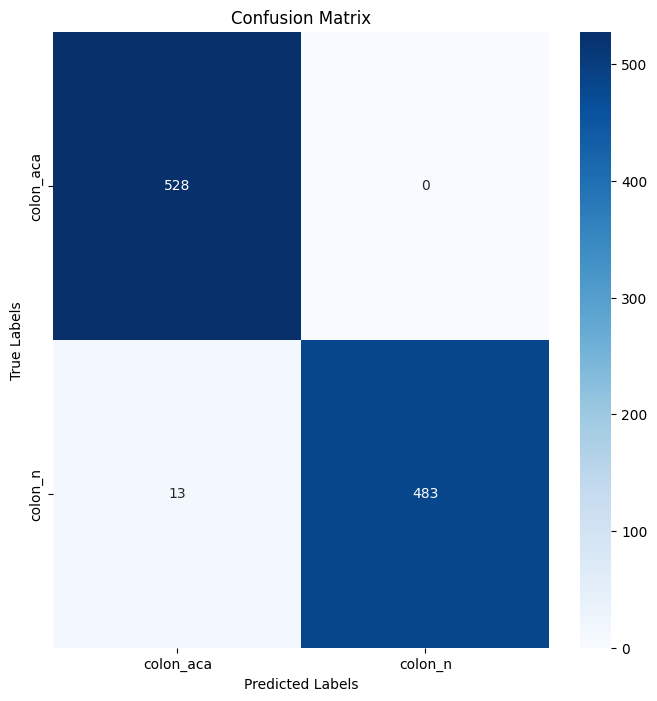

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have the trained model and test dataset
# model = ...
# test_ds = ...

# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_labels_batch)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Define class labels
class_labels = dataset.class_names

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [36]:
from sklearn.metrics import classification_report


# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_labels_batch)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=dataset.class_names)

print(report)


1/1 [==============================] - 1s 670ms/step
              precision    recall  f1-score   support

   colon_aca       0.98      1.00      0.99       528
     colon_n       1.00      0.97      0.99       496

    accuracy                           0.99      1024
   macro avg       0.99      0.99      0.99      1024
weighted avg       0.99      0.99      0.99      1024



In [39]:
# Assuming you have trained the model and assigned it to the 'model' variable

# Save the model in HDF5 format



Model saved.


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


1/1 [==============================] - 1s 582ms/step


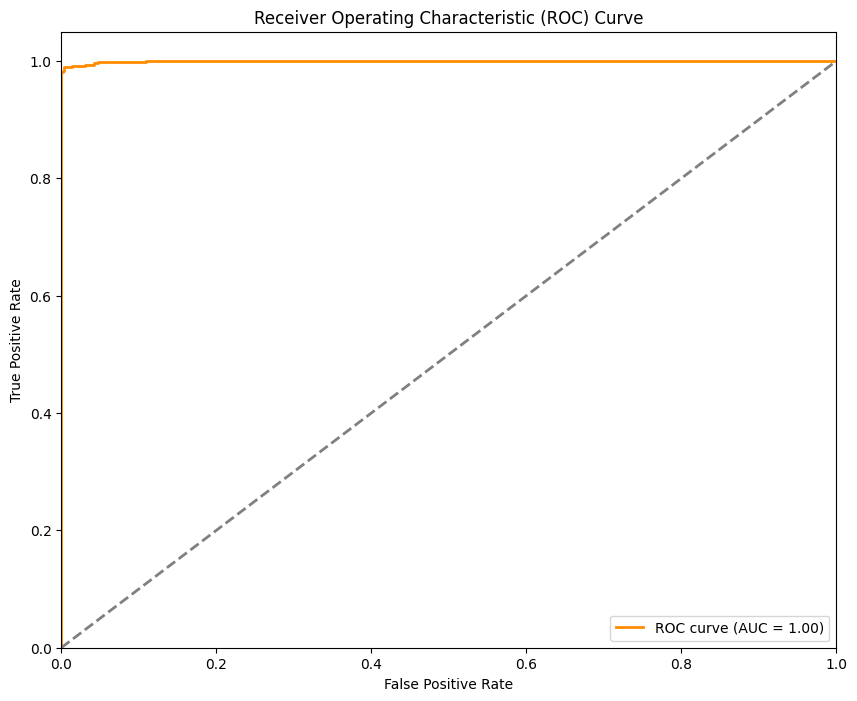

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the trained model and test dataset
# model = ...
# test_ds = ...

# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_probs_batch = predictions_batch[:, 1]  # Use probabilities for the positive class
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_probs_batch)

# Calculate the ROC curve and AUC-ROC
fpr, tpr, _ = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


1/1 [==============================] - 0s 475ms/step


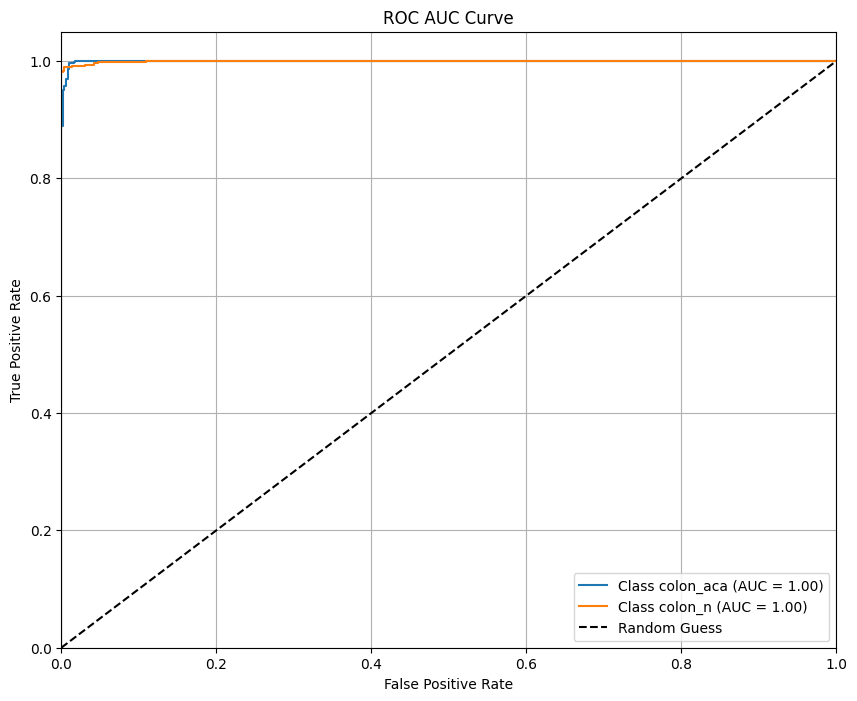

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have the trained model and test dataset
# model = ...
# test_ds = ...

# Get true labels and predicted probabilities
true_labels = []
predicted_probs = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_probs.extend(predictions_batch)
    true_labels.extend(labels_batch.numpy())

true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Calculate ROC curves and AUC for each class
n_classes = len(dataset.class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC AUC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {dataset.class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [57]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming you have the trained model and test dataset
# model = ...
# test_ds = ...

# Get true labels and predictions
true_labels = []
predictions = []

for image_batch, labels_batch in test_ds:
    predictions_batch = model.predict(image_batch)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    true_labels_batch = labels_batch.numpy()
    true_labels.extend(true_labels_batch)
    predictions.extend(predicted_labels_batch)

# Generate classification report
class_names = dataset.class_names
report = classification_report(true_labels, predictions, target_names=class_names)

# Print the formatted report
print("Classification Report:\n")
print(report)


1/1 [==============================] - 1s 584ms/step
Classification Report:

              precision    recall  f1-score   support

   colon_aca       0.98      1.00      0.99       528
     colon_n       1.00      0.97      0.99       496

    accuracy                           0.99      1024
   macro avg       0.99      0.99      0.99      1024
weighted avg       0.99      0.99      0.99      1024



In [59]:
model.save("try.h5")

print("Model saved.")

Model saved.
